In [1]:
import seaborn as sbn
import os
import cooltools.snipping
import cooltools.expected
import cooler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from scipy.stats import pearsonr
from collections import defaultdict
from scipy.stats import linregress
import matplotlib

# Define plotting parameters

In [2]:
matplotlib.rcParams.update({"pdf.fonttype": 42})

In [3]:
def convertToPosition(row):
    """Take a dataframe with chromosomes, Start_New and End_New
    as the start and end of the genomic intervals and converts them
    to genomic position tuple."""
    start = row["Start_New"]
    end = row["End_New"]
    center = start + (start-end)//2
    chrom = row["chr"]
    ID = row["ID"]
    return (chrom, center, ID)


def getColumnfromPosition(genomicPosition, dataFrame, column):
    ID = genomicPosition[2]
    field = dataFrame.loc[dataFrame["ID"] == ID, column]
    return field.values[0]

def recDict():
    return defaultdict(recDict)

In [4]:
os.chdir("/groups/gerlich/experiments/Experiments_004700/004738/")

# Load in Rugile's data

In [5]:
rData = pd.read_csv("/groups/gerlich/experiments/Experiments_004400"
                    "/004472/Datasets/Rugile_data_Raw_tracks_w_ID_newChromCoordinates.csv")
rDataSmall = rData[["G2_1.2h", "Start_New", "End_New", "chr"]]
rDataSmall.loc[:, "ID"] = rDataSmall.index

In [6]:
gPos = list(rDataSmall.apply(convertToPosition, axis=1).values)

In [7]:
splitDict = {}
for pos in gPos:
    splitDict[pos] = getColumnfromPosition(pos, rDataSmall, "G2_1.2h")

# Load in FISH data

In [8]:
fishData = pd.read_csv("./FISH_data.csv")

In [9]:
fishMerged = pd.merge(rData, fishData, on="ID")

In [10]:
fishMerged

,G1_18h,G1_17.4h,G1_16.8h,G1_16.2h,G1_15.6h,G1_15h,G1_14.4h,G1_13.8h,G1_13.2h,G1_12.6h,...,G2_1.2h,M_0h,ID,chr,Start,End,Start_New,End_New,State,FISH_distance
0,NaN,NaN,NaN,NaN,NaN,NaN,0.068287,0.066239,0.059685,0.043185,...,0.341538,0.671958,TMEM242,chr6,157732034,157733369,157631572,157733921,New,0.116822
1,NaN,NaN,NaN,NaN,NaN,NaN,0.047619,0.037037,0.000000,0.078704,...,0.510323,0.757576,Muc4,chr3,195506180,195510888,195505784,195515164,New,0.151565
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.105099,0.096170,...,0.507733,0.717369,Muc1,chr1,155161392,155161842,155161110,155161734,New,0.208333
3,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,0.084541,0.614652,sg12,chr7,157940082,157941453,157939644,157941830,New,0.052154
4,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.006173,...,0.124832,0.728632,sg36,chr4,187353774,187357874,187353774,187357874,Old_only,0.099609


In [11]:
gPosFish = list(fishMerged.apply(convertToPosition, axis=1).values)

In [19]:
gPosFish

[('chr6', 157580397, 'TMEM242'),
 ('chr3', 195501094, 'Muc4'),
 ('chr1', 155160798, 'Muc1'),
 ('chr7', 157938551, 'sg12'),
 ('chr4', 187351724, 'sg36')]

In [21]:
splitDictFISH = {}
for pos in gPosFish:
    splitDictFISH[pos] = getColumnfromPosition(pos,fishData , "FISH_distance")

# Load in Hi-C data

In [13]:
hiCPath = {"rep1": "/groups/gerlich/experiments/Experiments_004600/004605/Sequencing_data_Novaseq/cooler/GCCAAT",
           "rep2": "/groups/gerlich/experiments/Experiments_004600/004615/Sequencing_data/Novaseq/cooler/GTGAAA"}

basePath = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/"

barcodes="ATGTCA_S9 AGTCAA_S7 TTAGGC_S2 CCGTCC_S10 GATCAG_S5 CAGATC_S3 TAGCTT_S6 AGTTCC_S8 ACTTGA_S4".split(" ")
for index, barcode in enumerate(barcodes, start=3):
    hiCPath[f"rep{index}"] = os.path.join(basePath, barcode)

# Get average 1 - trans-sister contacts

In [22]:
halfWindowsize = 300000
BINSIZE = 10000
hiCValues = recDict()
hiCValuesCount = recDict()
for position in splitDictFISH.keys():
    chrom = position[0]
    start = position[1] - halfWindowsize
    end = position[1] + halfWindowsize
    for rep in hiCPath:
        clrs = {interType:
                cooler.Cooler(
                    f'{hiCPath[rep]}.{interType}.1000.mcool::/resolutions/{BINSIZE}')
                for interType in ["cis", "trans"]
                }
        cistemp = clrs["cis"].matrix(balance=False).fetch(f"{chrom}:{start}-{end}")
        transtemp = clrs["trans"].matrix(balance=False).fetch(f"{chrom}:{start}-{end}")
        hiCValues[rep][position] = 1 - np.nanmean(transtemp)
        hiCValuesCount[rep][position] = np.nansum(transtemp) + np.nansum(cistemp)

## Prepare data for plotting


In [23]:
hiCData = pd.DataFrame(hiCValues).reset_index()
hiCData.columns = ["chrom", "pos", "ID"] + ["rep" + str(i) for i in range(1, 12)]
# remove nans
hiCData = hiCData.replace([np.inf, -np.inf], np.nan).dropna(axis="rows")
# calculate z-score
for rep in ["rep" + str(i) for i in range(1, 12)]:
    hiCData.loc[:, rep] = (hiCData[rep] - np.nanmean(hiCData[rep]))/np.nanstd(hiCData[rep])
# merge with split values
splitValues = pd.DataFrame(splitDictFISH, index=[0]).transpose().reset_index()
splitValues.columns = ["chrom", "pos", "ID", "split"]
final = pd.merge(hiCData, splitValues, on="ID")

## Plot data

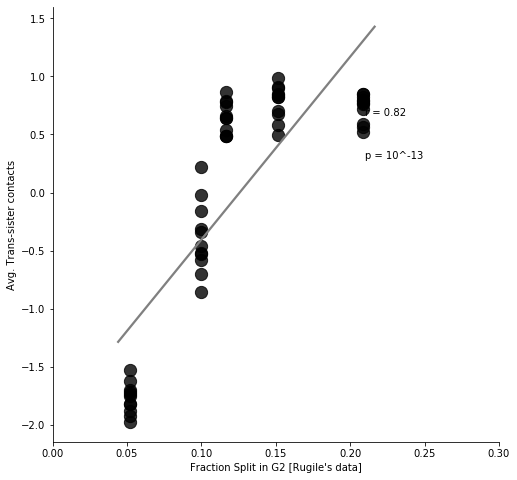

In [25]:
finalBoth = pd.melt(final[["split"] + ["rep" + str(i) for i in range(1, 12)]], id_vars="split")

corr, p = pearsonr(finalBoth["split"], finalBoth["value"])

orderOfMag = int(np.log10(p))

f, ax = plt.subplots()
sbn.regplot(x="split", y="value", data=finalBoth, ax=ax, ci=None,
            line_kws={"color": "grey"}, scatter_kws={"s": 150, "color": "black"})
ax.set_xlabel("Fraction Split in G2 [Rugile's data]")
ax.set_ylabel("Avg. Trans-sister contacts")
ax.text(0.7, 0.75, "r = {}".format(np.round(corr, 2)), transform=ax.transAxes)
ax.text(0.7, 0.65, f"p = 10^{orderOfMag}", transform=ax.transAxes)
ax.set_xlim(0, 0.3)
sbn.despine()
f.set_size_inches(8, 8)
plt.show()

## Plot summary

In [26]:
hiCFrame = final[["rep" + str(i) for i in range(1, 12)]]
means = hiCFrame.apply(np.nanmean, axis=1)
error = hiCFrame.apply(lambda x: np.nanstd(x), axis=1)

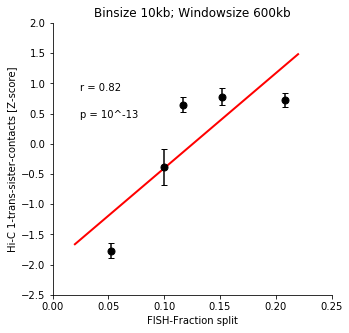

In [27]:
slope, intercept, r_value, p_value, std_err = linregress(finalBoth["split"], finalBoth["value"])

orderOfMag = int(np.log10(p_value))

f, ax = plt.subplots()
ax.errorbar(final["split"], means, error, fmt="o", capsize=3, color="black", markersize=7)
ax.plot(np.arange(0.02, 0.25, 0.1), intercept + slope * np.arange(0.02, 0.25, 0.1), ls="-", color="red", lw=2)
ax.text(0.1, 0.75, "r = {}".format(np.round(r_value, 2)), transform=ax.transAxes)
ax.text(0.1, 0.65, f"p = 10^{orderOfMag}", transform=ax.transAxes)
ax.set(xlabel="FISH-Fraction split", ylabel="Hi-C 1-trans-sister-contacts [Z-score]", xlim=(0, 0.25) , ylim=(-2.5, 2), title="Binsize 10kb; Windowsize 600kb")
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

In [28]:
p_value

1.3445159324379249e-14

In [33]:
resultsDir = "/groups/gerlich/experiments/Experiments_004700/004738/Results"
f.savefig(os.path.join(resultsDir, "Correlation_trans_allReps_together_FISH.png"),
          bbox_inches="tight")
f.savefig(os.path.join(resultsDir, "Correlation_trans_allReps_together_FISH.pdf"),
          bbox_inches="tight")